In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPooling1D,UpSampling1D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

from AD_tools import * # specifically need training()

In [2]:
# J_x/J_||   extrap    lower   upper
theory_1st = np.loadtxt("data/theory_1st.txt")
theory_2nd = np.loadtxt("data/theory_2nd.txt")

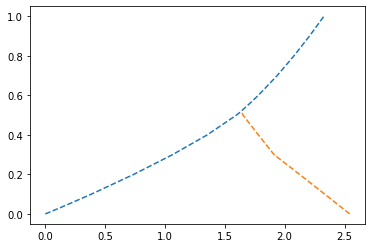

In [3]:
plt.plot(theory_1st[:,1],theory_1st[:,0],"--")
plt.plot(theory_2nd[:,1],theory_2nd[:,0],"--")

In [4]:
plt.rcParams.update({
    'figure.figsize': (6,5),
    'font.size': 16,
    })

In [5]:
name = "2-2"

In [6]:
data = np.loadtxt("data/dataD62siteRDM2D.txt")
data.shape

(5151, 73)

In [7]:
xx, yy = data[:,0], data[:,1]

In [8]:
x_data = data[:,3:]

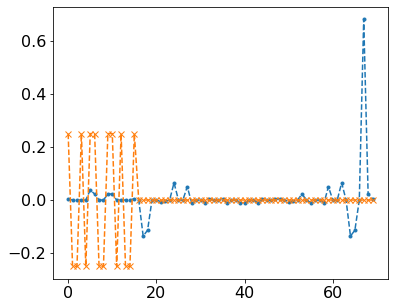

In [9]:
plt.plot(x_data[0],".--")
plt.plot(x_data[-1],"x--")

In [10]:
x_test = x_data[:,:,np.newaxis]
x_test.shape

(5151, 70, 1)

In [11]:
def train_mask(x0,x1,y0,y1):
    pick_x = np.where((xx >= x0) & (xx <= x1))
    pick_y = np.where((yy >= y0) & (yy <= y1))
    return np.intersect1d(pick_x,pick_y)

In [12]:
ux = np.unique(xx)
uy = np.unique(yy)
X,Y = np.meshgrid(ux,uy)

In [13]:
rate=0.2 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences
fully = True

In [14]:
def cnnx(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,)),dim2=(16,(3,)), fully=False):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    #x1 = Conv1D(*dim1, activation=activation0, padding='same')(input_img)
    #x2 = MaxPooling1D((2,), padding='same')(x1)
    #x2 = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    #x3 = MaxPooling1D((2,), padding='same')(x2)
    #encoded = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    
    encoded = Flatten()(input_img)
    encoded = Dense(units=100,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(units=25,activation=activation0)(encoded)
    
    y = Dense(units=100,activation=activation0)(encoded)
    y = tf.keras.layers.Dropout(rate)(y)

    #y=UpSampling1D(2)(encoded)
    #y=Conv1D(*dim1, activation=activation0, padding='same')(y)
    #y=UpSampling1D(2)(y)
    decoded = Dense(np.prod(in_dim), activation=activation)(y)
    decoded = tf.keras.layers.Reshape(in_dim)(decoded)
    

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [15]:
# Show Network architecture
cnn = cnnx("mse","adam","linear","relu",x_shape=(6,4))
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 4)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

In [16]:
def norm2(y_true,y_pred):
    """ just the standard l2 norm, needed for evaluation """
    return np.sqrt(np.sum(np.abs(y_true - y_pred)**2))

def eval_loss(x_batch,y_batch,norm=norm2):
    a = []
    for i in range(x_batch.shape[0]):
        a.append(norm(x_batch[i],y_batch[i]))
    return np.array(a)

def training_run(x_train,choose_cnn, name = "", provide_cnn = False,
             load_prev=False, num_epochs = 10,  verbose_val=1, batch_size = 128, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
             dim1=(16,(3,3)),dim2=(16,(3,3)),ssc1=False,ssc2=False):
    """
    provide_cnn is to continue the training of a cnn
    load_prev is to load a previously trained network under the same paramters
    x_train provide training data
    """
        
    name_string = name
    CNN_filepath= 'CNN_data/Anomaly-Detection_' + name_string + 'weights.hdf5'

    cnn = choose_cnn(loss,optimizer,activation0,activation,x_train.shape[1:],dim1,dim2) #ssc1, ssc2
    if load_prev:
        cnn.load_weights(CNN_filepath)
    else:
        if provide_cnn:
            cnn = provide_cnn
        # checkpoint
        checkpoint = ModelCheckpoint(CNN_filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='max')
        callbacks_list = [checkpoint]
        if early:
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)#, restore_best_weights=True)
            callbacks_list.append(early_stop)

        history=cnn.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_train,x_train),callbacks=callbacks_list,verbose=verbose_val,shuffle=shuffle)
        np.savez('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',loss=history.history['loss'],val_loss=history.history['val_loss'])#,acc=history.history['acc'],val_acc=history.history['val_acc'])

    # training history
    plotname = 'plots/Anomaly-Detection_training-history' +  name_string
    hist = np.load('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',allow_pickle="True")
    loss = hist["loss"]
    val_loss = hist["val_loss"]
    plt.plot(loss, linewidth=2, label='Train')
    plt.plot(val_loss, linewidth=2, label='Val')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale("log")
    #plt.ylim(ymin=0.70,ymax=1)
    plt.savefig(plotname + 'training.png', format="png")
    plt.show()
    return cnn

In [17]:
def create_out(cnn1):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    images_out = cnn1.predict(x_test)

    res = eval_loss(x_test,images_out,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)

    out = np.zeros((len(uphase),len(ufreq)))
    dout = np.zeros((len(uphase),len(ufreq)))

    for i,ph in enumerate(uphase):
        for j,fr in enumerate(ufreq):
            mask = np.intersect1d(np.where(freq == fr),np.where(phase == ph))
            out[i,j] = np.mean(res[mask])
            dout[i,j] = np.std(res[mask])
    return out, dout, res

In [18]:
# this is here the results, i.e. the loss values and its error are going to be saved
# res is the full-stack data list while out is averaged and aranged
cnns, outs, douts, res = [None] * 3,[None] * 3, [None] * 3, [None] * 3 

In [19]:
train_xss = [[(0,1)],[(3,4)],[(1,2)]]
train_yss = [[(0.8,1)],[(0.8,1)],[(0,0.1)]]

[(286, 70, 1)]
(286, 70, 1)
Epoch 1/100
3/3 [==============================] - 1s 223ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 7/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 8/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 9/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0032 - val_los

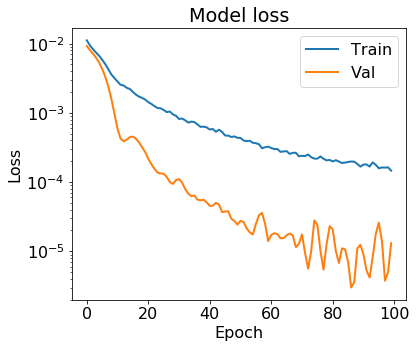

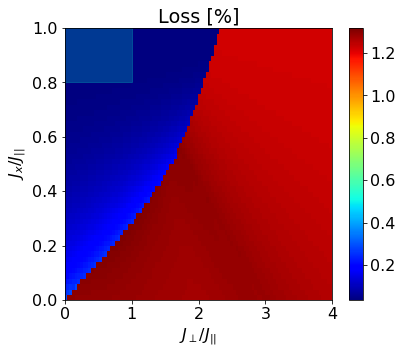

[(286, 70, 1)]
(286, 70, 1)
Epoch 1/100
3/3 [==============================] - 1s 121ms/step - loss: 0.0156 - val_loss: 0.0123
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0125 - val_loss: 0.0105
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 8/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 9/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0030 - val_loss: 7.3503e-04
Epoch 10/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0025 - val

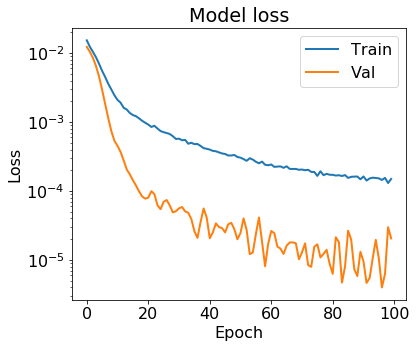

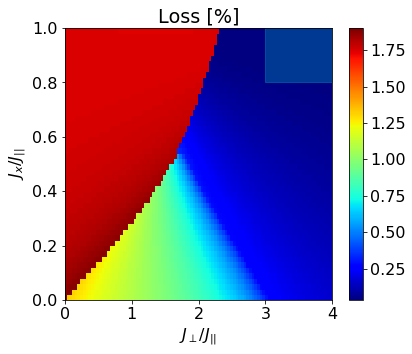

[(156, 70, 1)]
(156, 70, 1)
Epoch 1/100
2/2 [==============================] - 0s 138ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 4/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 5/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 7/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 8/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 9/100
2/2 [==============================] - 0s 135ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 10/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0052 - val_lo

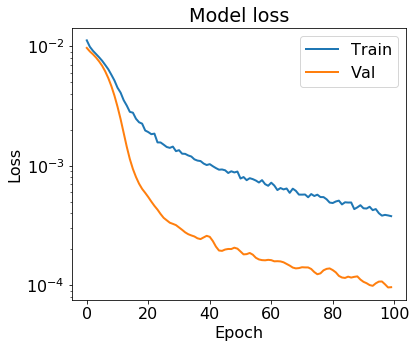

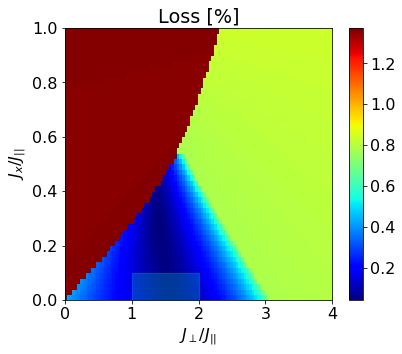

In [20]:
for training in range(3):
    tf.keras.backend.clear_session()
    train_xs = train_xss[training]
    train_ys = train_yss[training]
    x_train = []
    for xs,ys in zip(train_xs,train_ys):
        x_train.append(x_test[train_mask(*xs,*ys)])
    print([_.shape for _ in x_train])
    x_train = np.concatenate(x_train)
    print(x_train.shape)

    cnns[training] = training_run(x_train,choose_cnn = cnnx, name = name, provide_cnn = False,
                 load_prev=False, num_epochs = 100,  verbose_val=1, batch_size = 128, shuffle=True, early=False,
                 loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam")

    images_out = cnns[training].predict(x_test)
    res = eval_loss(x_test,images_out,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)
    outs[training] = res.reshape(51,101)

    fig, ax = plt.subplots()
    # plot result
    im = ax.pcolormesh(X,Y,outs[training],cmap="jet")
    fig.colorbar(im,ax=ax)
    for xs,ys in zip(train_xs,train_ys):
        plt.fill_between(*[xs],*ys,color="c",alpha=0.3)
    ax.set_xlabel("$J_\perp/J_{{||}}$")
    ax.set_ylabel("$J_x/J_{{||}}$")
    ax.set_title("Loss [%]")
    plt.savefig("plots/" + name + f"_training_{training}.png")
    plt.show()

In [21]:
temps = [np.load("data_results/2-0_data.npz",allow_pickle=True),
         np.load("data_results/2-1_data.npz",allow_pickle=True)]

In [22]:
label = ["$\lambda^k_\ell$", "$\\rho^{{(2)}}$"]

(0, 1) (0.8, 1)
(3, 4) (0.8, 1)
(1, 2) (0, 0.1)


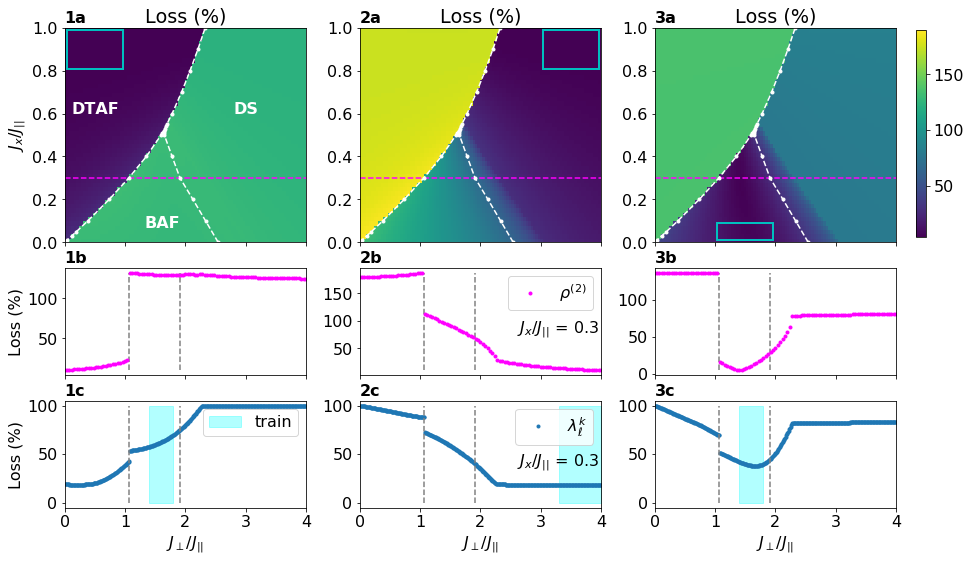

In [25]:
fig, axs = plt.subplots(3, 3, gridspec_kw={'height_ratios': [3, 1.5,1.5]},figsize=(14,8),sharex="col") #,sharey="row")
#set_share_axes(axs[1:,:], sharex=True)
fillalpha, fillcolor = 0.5, "c"
cmap = "viridis" #"viridis" #"seismic" # "jet","seismic" # good diverging cmap: "seismic" https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin, vmax = 100*np.nanmin(outs), 100*np.nanmax(outs)
pickys = [15,15,15]
for i in range(3):
    ax = axs[0,i]
    im = ax.pcolormesh(X,Y,100*outs[i],cmap=cmap,vmin=vmin, vmax=vmax,linewidth=0,rasterized=True) #, vmin=vmin, vmax=vmax
    im.set_edgecolor('face')
    #cbar = fig.colorbar(im,ax=ax)
    ax.set_title("Loss (%)")
    for phases,freqs in zip(train_xss[i],train_yss[i]):
        print(phases,freqs)
        # I am sure this can be done more elegantly, but aint nobody got time for that:
        rectcolor="c"
        ax.plot([phases[0]+0.04,phases[1]-0.04],[freqs[0]+0.01]*2,"-",linewidth=2,color=rectcolor)
        ax.plot([phases[0]+0.04,phases[1]-0.04],[freqs[1]-0.01]*2,"-",linewidth=2,color=rectcolor)
        ax.plot([phases[0]+0.04]*2,[freqs[0]+0.01,freqs[1]-0.01],"-",linewidth=2,color=rectcolor)
        ax.plot([phases[1]-0.04]*2,[freqs[0]+0.01,freqs[1]-0.01],"-",linewidth=2,color=rectcolor)
        #ax.plot(phases,[freqs[0]]*2,"-",linewidth=1,color=rectcolor)
        #ax.plot(phases,[freqs[1]]*2,"-",linewidth=1,color=rectcolor)
        #ax.plot([phases[0]]*2,freqs,"-",linewidth=1,color=rectcolor)
        #ax.plot([phases[1]]*2,freqs,"-",linewidth=1,color=rectcolor)
    pick_phase= pickys[i]
    ax.plot([0,4],[Y[pick_phase,0]]*2,"--",color="magenta",label="$\\rho^{{(2)}}$")
    ax = axs[1,i]
    single_cut = 100*outs[i][pick_phase]
    
    ax.plot([theory_1st[6,1]]*2,[single_cut.min(),single_cut.max()],"--",color="grey")
    ax.plot([theory_2nd[3,1]]*2,[single_cut.min(),single_cut.max()],"--",color="grey")
    label = None
    ax.plot(X[pick_phase],single_cut,".",label="$\\rho^{{(2)}}$",color="magenta")
axs[1,1].legend()
# Third row single cut data
label = ["$\lambda^k_\ell$", "$\\rho^{{(2)}}$"]
for col in [0]: # decided just to show lambda
    outsX = temps[col]["outs"]
    xxX = temps[col]["xx"]
    train1s = temps[col]["train1s"]
    for i,train1 in enumerate(train1s):
        ax = axs[2,i]
        out = outsX[i]/np.max(outsX[i])
        if i == 1:
            ax.plot(xxX,100*out,".",label=label[col]) #,label="$\lambda^k_\ell$")
        else:
            ax.plot(xxX,100*out,".")
axs[2,0].fill_between(*[train1s[i]],-0.5,100,alpha=0.3,color="cyan",label="train")
for i in range(3):
    if i != 0:
        axs[2,i].fill_between(*[train1s[i]],-0.5,100,alpha=0.3,color="cyan")
    axs[2,i].plot([theory_1st[6,1]]*2,[-0.5,100],"--",color="grey")
    axs[2,i].plot([theory_2nd[3,1]]*2,[-0.5,100],"--",color="grey")
axs[2,0].legend()
axs[2,1].legend()


handles, labels = axs[1,0].get_legend_handles_labels()
#axs[1,0].legend(handles, labels,bbox_to_anchor=(0.3, 1.02, 2.5, .102), loc='lower left',
#           ncol=5, mode="expand", borderaxespad=0.)
theorycolor="white"
for i in range(3):
    axs[0,i].plot(theory_1st[:,1],theory_1st[:,0],".--",color=theorycolor,label="Extrap. Transition")
    axs[0,i].plot(theory_2nd[:,1],theory_2nd[:,0],".--",color=theorycolor)

plt.tight_layout()
for i in range(3):
    axs[2,i].set_xlabel("$J_\perp/J_{{||}}$")
    #axs[1,i].text(0.35, 1.1,"$J_x/J_{{||}}$ = {:.1f}".format(Y[pick_phase,0]), transform = axs[1,i].transAxes,fontsize=16)
axs[1,1].text(0.65,0.4,"$J_x/J_{{||}}$ = {:.1f}".format(Y[pick_phase,0]),fontsize=16,transform = axs[1,1].transAxes)
axs[2,1].text(0.65,0.4,"$J_x/J_{{||}}$ = 0.3",fontsize=16,transform = axs[2,1].transAxes)
axs[1,0].set_ylabel("Loss (%)")
axs[2,0].set_ylabel("Loss (%)")
axs[0,0].set_ylabel("$J_x/J_{{||}}$")


axs[0,0].text(0.03, 0.6,"DTAF",weight="bold", color="white", transform = axs[0,0].transAxes,fontsize=16)
axs[0,0].text(0.33, 0.07,"BAF",weight="bold", color="white", transform = axs[0,0].transAxes,fontsize=16)
axs[0,0].text(0.7, 0.6,"DS",weight="bold", color="white", transform = axs[0,0].transAxes,fontsize=16)

for i in range(3):
    axs[0,i].text(0, 1.025,f"{i+1}a",weight="bold", transform = axs[0,i].transAxes,fontsize=16)
    axs[1,i].text(0, 1.05,f"{i+1}b",weight="bold", transform = axs[1,i].transAxes,fontsize=16)
    axs[2,i].text(0, 1.05,f"{i+1}c",weight="bold", transform = axs[2,i].transAxes,fontsize=16)
# colorbar

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.57, 0.01, 0.36]) #left, bottom, width, height
fig.colorbar(im, cax=cbar_ax)
#cbar_ax.set_title("  Loss (%)")
plt.gcf().subplots_adjust(bottom=0.1,left=0.075)
plt.savefig("plots/post-selected_master_" + cmap + ".pdf")
plt.savefig("plots/post-selected_master_" + cmap + ".png")